# Figure 2 - The normalizing effect of a random dynamical nudge based on the central limit theorem.

Given a polarized network of agents (a), the mean of the opinions $\langle X \rangle$ at $t=5$ is close to 0. An approximation of this mean value, using the Central Limit Theorem (CLT), was gathered by sampling 30 opinions $\langle X_{30} \rangle$ (i.e. with sample size $n$ of 30) a thousand times at $t=5$ and taking the mean of these sample means: $\langle \langle X_{30} \rangle \rangle$ (b). Applying an RDN formulated as a CLT term, but where each agent sees the same sample mean $\langle X_n \rangle$, was insufficient to achieve a normal distribution of agent opinions (c), regardless of RDN strength $D$ (d). Instead, each agent must see their own sample mean  $\langle X_n \rangle_{i}$ to prevent a network from becoming polarized (e). This was true for different RDN strengths ($D \in \{0, 1, 3, 5\}$). Varying the sample size $n$ did not significantly change distributions. The RDN causes the opinions to be predominantly neutral ($\approx 0$) and prevented the formation of echo chambers. Large RDN values (e.g. $D=5$) also have more agents with extreme opinions. Other parameters were $N=1000$, $K = 3$, $\beta=3$, $\alpha=3$, $m=10$, $r=0.5$, $T=5$, and $n=30$ unless otherwise stated.

In [1]:
#@title Colab Setup { display-mode: "form" }
import sys

# for persisting data across sessions
connect_gdrive = False #@param {type:"boolean"}
cache_dir = ".cache" #param {allow-input: true}

try:
    from google.colab import drive

    # Clone github repository
    GIT_REPO = "https://github.com/ChrisCurrin/opinion_dynamics.git"
    !rm -rf ./temp
    !git clone --quiet "{GIT_REPO}" ./temp

    # add to path
    sys.path.append('./temp')
    # need latest tqdm version for tenumerate and tables to prevent HDF read error
    # !pip install -q --upgrade tqdm tables
    # !pip install -q --upgrade vaex IPython

    if connect_gdrive:
        # connect GDrive for retrieving/saving results
        drive.mount('/content/drive')

        # create symlink between a Drive folder and the cache for persistence between sessions
        import os
        try:
            os.makedirs("/content/drive/My Drive/Colab Notebooks/opdynamics/.cache")
            os.makedirs("/content/drive/My Drive/Colab Notebooks/opdynamics/output")
        except IOError:
            pass
        !ln -s "/content/drive/My Drive/Colab Notebooks/opdynamics/.cache" ".cache"
        !ln -s "/content/drive/My Drive/Colab Notebooks/opdynamics/output" "output"

except ModuleNotFoundError:
    print(f"local notebook on {sys.platform}")
    pass

local notebook on win32


In [2]:
#@title Imports and settings { display-mode: "form" }

dark = True # @param {type:"bool"}

%reload_ext autoreload
%autoreload 2

import logging
import itertools
import os
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from tqdm.notebook import tqdm
from matplotlib.colors import LogNorm
from matplotlib.cbook import flatten
from matplotlib.collections import PolyCollection

try:
    import opdynamics.simulation as Simulation
except AttributeError:
    raise RuntimeError("restart runtime")
from opdynamics.socialnetworks import (SocialNetwork, ConnChamber, ContrastChamber, OpenChamber, SampleChamber)
from opdynamics.visualise import (VisSocialNetwork,
                                  show_K_alpha_phase,
                                  show_activity_vs_opinion,
                                  show_jointplot,
                                  show_noise_panel,
                                  show_opinion_grid,
                                  )
from opdynamics.metrics.opinions import calc_distribution_differences, distribution_modality
from opdynamics.visualise import plot_surface_product, plot_surfaces
from opdynamics.utils.distributions import negpowerlaw
from opdynamics.utils.plot_utils import df_multi_mask, move_cbar_label_to_title
from opdynamics.utils.cache import get_cache_dir, set_cache_dir, process_cache_arg
from opdynamics.utils.logging import LoggingContext
from opdynamics.utils.constants import *
from opdynamics.visualise.compat import sns_kdeplot

try:
    os.makedirs("output")
except FileExistsError:
    pass

old_cache_dir, new_dir = set_cache_dir(cache_dir)

np.random.seed(1337)

sns.set_theme(context="notebook", style="ticks",
        rc={
            "pdf.fonttype": 42, # embed font in output
            "svg.fonttype": "none",  # embed font in output
            # "figure.facecolor":"white",
            
            "axes.spines.left": True,
            "axes.spines.bottom": True,
            "axes.spines.right": False,
            "axes.spines.top": False,
            "figure.dpi": 200,
            }
        )

if dark:
    plt.style.use("dark_background")

# some settings get reset by dark_background
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["axes.facecolor"] = "None"

logging.basicConfig(level=logging.INFO)
logging.getLogger().setLevel(logging.INFO)
logging.getLogger("matplotlib").setLevel(logging.INFO)
logging.getLogger("asyncio").setLevel(logging.WARNING)

c:\Users\ccurrin\Anaconda3\envs\opinion_dynamics\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Central Limit Theorem

The Central Limit Theorem states...

> Sample means are normally distributed.

> The mean of sample means approximates the true mean of the population.


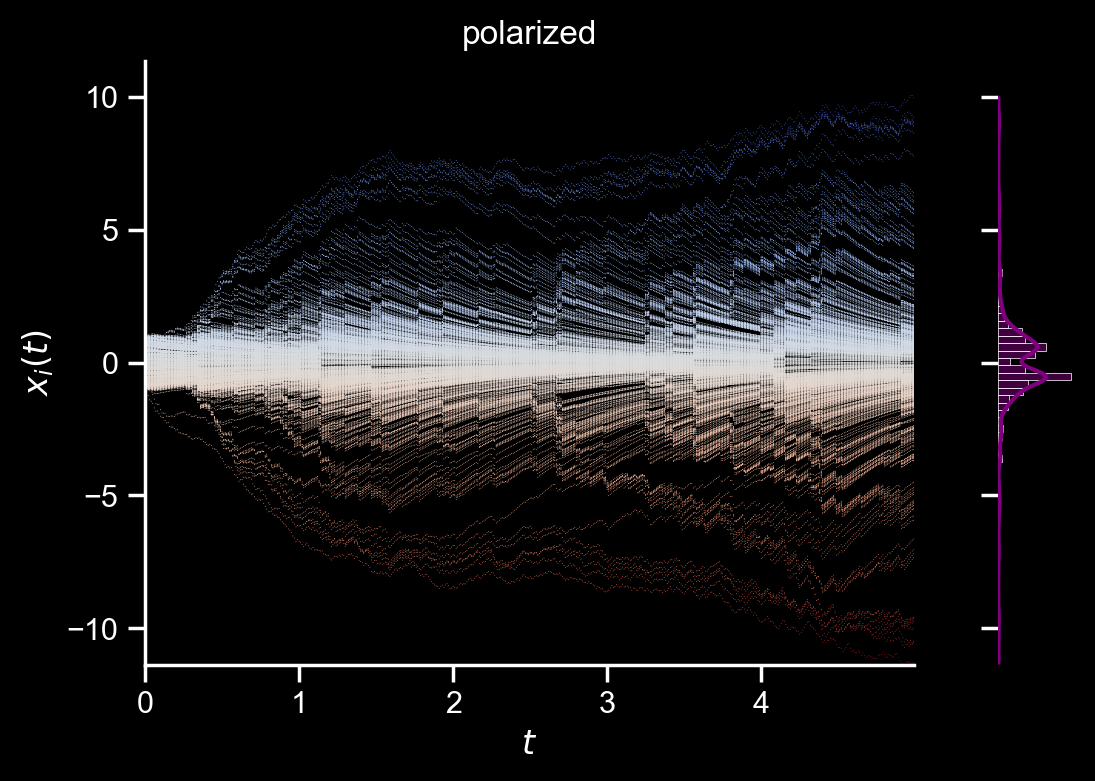

In [3]:
# title Set up polarised opinions { display-mode: "form" }
kwargs = dict(
    N=1000,
    m=10,
    T=5,
    epsilon=1e-2,
    gamma=2.1,
    r=0.5,  # probability of mutual interaction
    dt=0.01,
    K=3,
    alpha=3,
    beta=3,
    activity_distribution=negpowerlaw,
    plot_opinion=True,
    cache="all",
)
with LoggingContext(logging.INFO):
    sn_polar = Simulation.run_params(SocialNetwork, name="polarized", **kwargs)


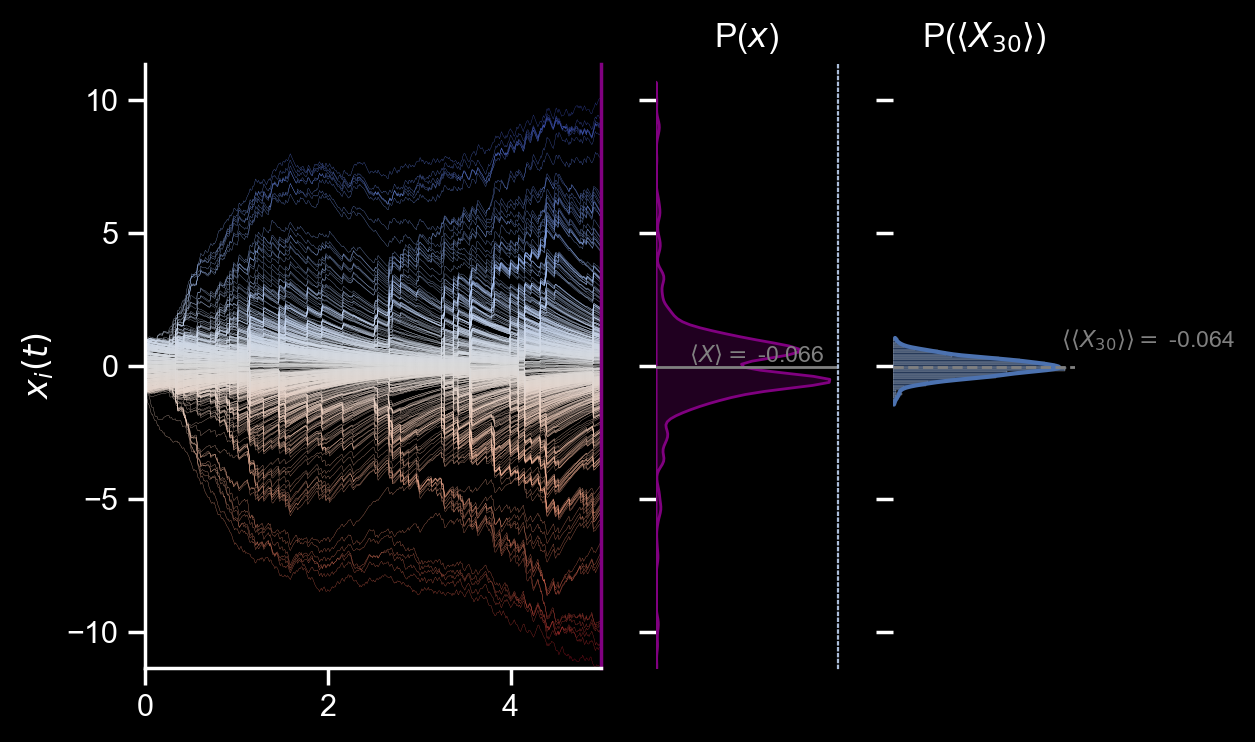

In [4]:
# title Check sample size and number of samples { run: "auto", display-mode: "form" }

sample_size = 30  # @param {type:"slider", min:1, max:1000, step:1}
num_samples = 1000  # @param {type:"slider", min:1, max:1000, step:1}

fig, axes = plt.subplots(
    nrows=1,
    ncols=3,
    squeeze=False,
    # figsize=(7.2, 5),
    gridspec_kw={"width_ratios": [1, 0.4, 0.4], "height_ratios": [1]},
    sharey=True,
    sharex=False,
)
fig.subplots_adjust(hspace=0.5)
# fig.subplots_adjust(wspace=0.05)
VisSocialNetwork(sn_polar).show_opinions(
    "line", ax=axes[0, 0], title="", rasterized=True
)
sns.kdeplot(
    y=sn_polar.opinions,
    ax=axes[0, 1],
    shade=True,
    bw_adjust=0.5,
    color="Purple",
)
sample_means = sn_polar.get_sample_means(sample_size, num_samples)
mu = np.mean(sample_means)

sns.histplot(y=sample_means, kde=True, ax=axes[0, 2])

ax = axes[0, -1]
ax.annotate(
    f"$ \langle \langle X_{{{sample_size}}} \\rangle \\rangle =$ {mu:.3f}",
    xy=(ax.get_xlim()[1], mu),
    xytext=(-5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize="x-small",
    color="gray",
    # arrowprops=dict(arrowstyle='-|>'),
)
ax.axhline(y=mu, color="gray", linestyle="--", lw=1)

ax = axes[0, -2]
true_mu = np.mean(sn_polar.opinions)
ax.annotate(
    f"$\langle X \\rangle =$ {true_mu:.3f}",
    xy=(ax.get_xlim()[1], true_mu),
    xytext=(-5, 0),
    textcoords="offset points",
    ha="right",
    va="bottom",
    fontsize="x-small",
    # arrowprops=dict(arrowstyle='-|>'),
    zorder=100,
    clip_on=False,
    color="gray",
)
ax.axhline(y=true_mu, color="gray", linestyle="-", lw=1)

axes[0, -2].set_title(f"P({OPINION_SYMBOL})")
axes[0, -1].set_title(f"P($\langle X_{{{sample_size}}} \\rangle$)")
# ax.set_ylabel(f"$P(\overline{{X}}_n)$\n[# samples = {num_samples}]")
# ax.set(yticks=False,)
sns.despine(ax=axes[0, 0], right=False)
axes[0, 0].spines["right"].set_color("Purple")
axes[0, 0].set_xlabel("")

for ax in axes[0, -2:]:
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set(xticks=[], xlabel="")
axes[0, -2].spines["right"].set_visible(True)
axes[0, -2].spines["right"].set_color("#abbdd9")
axes[0, -2].spines["right"].set_linestyle(":")
axes[0, -2].spines["right"].set_linewidth(0.8)


## SampleChamber

Add a "population opinion" term that captures the Lindeberg–Lévy Central Limit Theorem.

$\dot{x}_i = K \sum^{N}_{j=1} A_{ij} (t)  \tanh(\alpha_1 x_j)  + D \cdot \sqrt {n}\left({\langle X_{n} \rangle}-\mu \right)$

where $X$ is a random sample and ${\langle X_{n} \rangle}$ is the sample mean for $n$ random samples.

According to CLT, the means of random samples are normally distributed.

By substracting the true (or accurate estimate of the ) mean, $\mu$, and scaling by sample size ($\sqrt{n}$),
the normal distribution is centered on $0$.

$\sqrt {n}\left({\langle X \rangle}-\mu \right) \rightarrow \mathcal{N}\left(0,\sigma^{2}\right)$

| Symbol | Keyword       | Class (inherits from)               | Meaning                                      | Range ($\mathbb{R}$) |
| ------ | ------------- | ----------------------------------- | -------------------------------------------- | -------------------- |
| $n$    | `sample_size` | `SampleChamber(NoisySocialNetwork)` | Number of opinions to sample from all agents | $[0,N]$              |


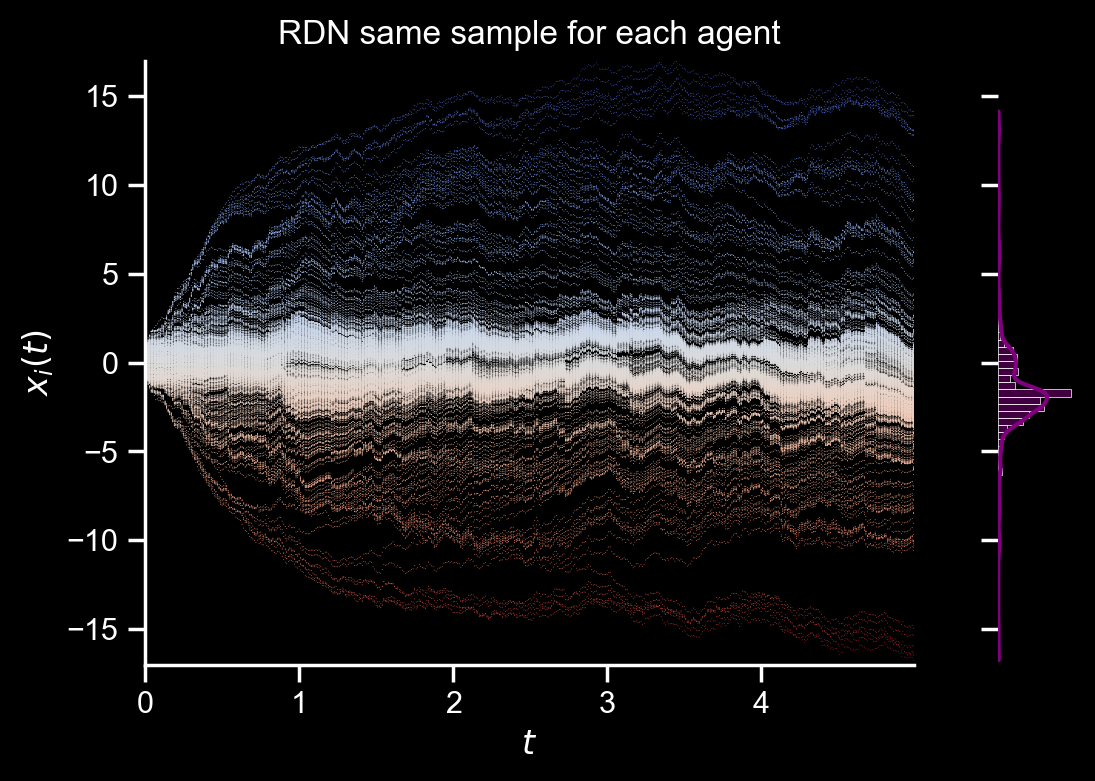

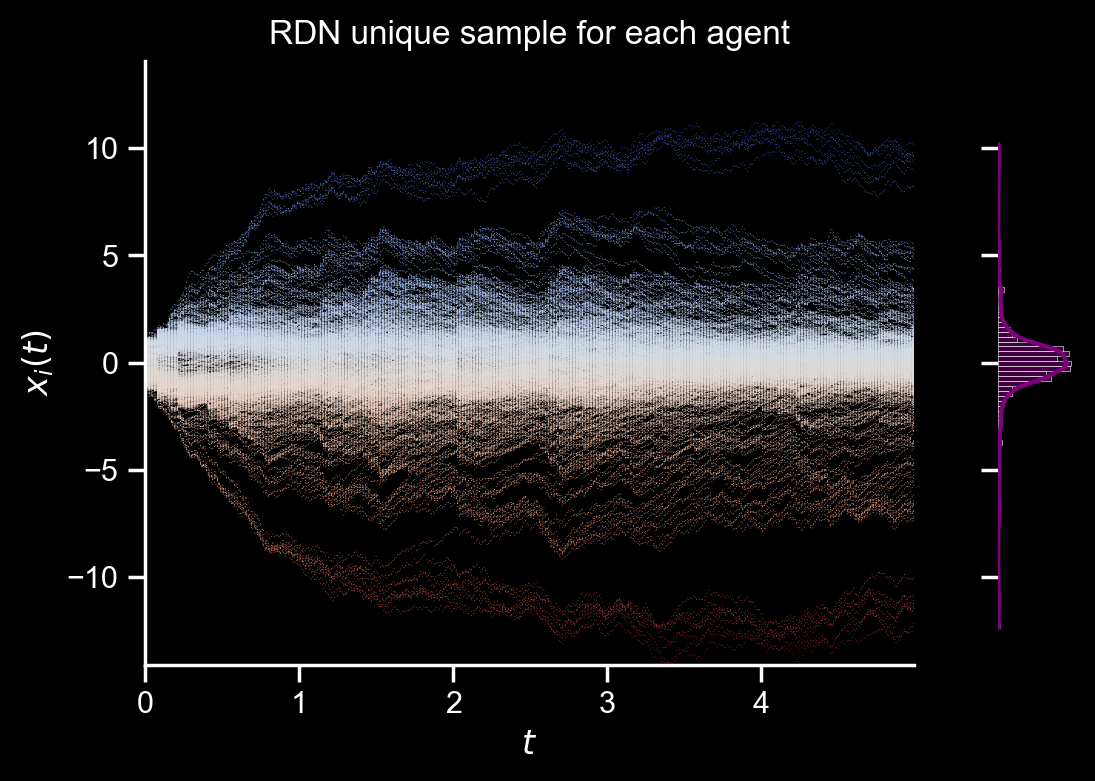

In [5]:
# title 2 versions of SampleChamber { display-mode: "form" }
kwargs = dict(
    N=1000,
    m=10,
    T=5,
    epsilon=1e-2,
    gamma=2.1,
    r=0.5,  # probability of mutual interaction
    dt=0.01,
    K=3,
    alpha=3,
    beta=3,
    activity_distribution=negpowerlaw,
    plot_opinion=True,
    cache="all",
)
with LoggingContext(logging.INFO):
    chosen_D = 3.0

    sn_D_n1 = Simulation.run_params(
        cls=SampleChamber,
        D=chosen_D,
        num_samples=1,
        name="RDN same sample for each agent", 
        **kwargs,
    )

    sn_D_nN = Simulation.run_params(
        cls=SampleChamber,
        D=chosen_D,
        name="RDN unique sample for each agent", 
        **kwargs,
    )

## Run a range of parameters for SampleChamber with the **same** sample

$\mathrm{RDN} = \sqrt {n}\left( \langle X_{n} \rangle - \langle X \rangle \right)$



In [6]:
# title Run a range of parameters for SampleChamber with the same sample { display-mode: "form" }

parameters = dict(
    N=1000,
    m=10,
    T=5.0,
    epsilon=1e-2,
    gamma=2.1,
    dt=0.01,
    r=0.5,
    update_conn=True,
    cls=SampleChamber,
    method="RK45",
    name="sample chamber",
    num_samples=1,
)

D_range = np.round(np.arange(0.0, 5.0001, 1), 3)

sample_size_range = [1, 30, 50]

range_parameters = {
    "D": {"range": D_range, "title": "D"},
    "sample_size": {"range": sample_size_range, "title": "n"},
    "alpha": {"range": [3], "title": "α"},
    "beta": {"range": [3], "title": "β"},
    "K": {"range": [3], "title": "K"},
    "background": {"range": [True]},
    "sample_method": {
        "range": ["full"],
        "title": "sample method",
    },
    "seed": [1337, 10101, 12345],
}

with LoggingContext(logging.INFO):
    df_rdn_same = Simulation.run_product(
        range_parameters,
        noise_start=0,
        cache=True,
        # cache_sim="nudge_single_sample",
        # cache_sim=False,
        cache_mem=False,
        parallel=10,
        **parameters
    )
df_rdn_same

INFO:simulation:reading from existing file...
INFO:simulation:running 0 new simulations (out of 54 supplied) in parallel
parallel: 0it [00:00, ?it/s]INFO:simulation:done running
INFO:simulation:loading full DataFrame from storage
parallel: 0it [00:00, ?it/s]


#       i    opinion              N     m    T    epsilon    gamma    dt    r    update_conn    name            num_samples    D    sample_size    alpha    beta    K    background    sample_method    seed    cls    method    activity_distribution
0       0    0.4471247732662511   1000  10   5.0  0.01       2.1      0.01  0.5  True           sample chamber  1              0.0  1              3        3       3    True          full             1337           RK45
1       1    -0.6220150247843225  1000  10   5.0  0.01       2.1      0.01  0.5  True           sample chamber  1              0.0  1              3        3       3    True          full             1337           RK45
2       2    0.6989110768850766   1000  10   5.0  0.01       2.1      0.01  0.5  True           sample chamber  1              0.0  1              3        3       3    True          full             1337           RK45
3       3    0.8437569910431311   1000  10   5.0  0.01       2.1      0.01  0.5  True           sample chamber  1              0.0  1              3        3       3    True          full             1337           RK45
4       4    0.3792320855802612   1000  10   5.0  0.01       2.1      0.01  0.5  True           sample chamber  1              0.0  1              3        3       3    True          full             1337           RK45
...     ...  ...                  ...   ...  ...  ...        ...      ...   ...  ...            ...             ...            ...  ...            ...      ...     ...  ...           ...              ...     ...    ...       ...
53,995  995  1.8631663189072958   1000  10   5.0  0.01       2.1      0.01  0.5  True           sample chamber  1              5.0  50             3        3       3    True          full             12345          RK45
53,996  996  0.29399639819995915  1000  10   5.0  0.01       2.1      0.01  0.5  True           sample chamber  1              5.0  50             3        3       3    True          full             12345          RK45
53,997  997  0.1858380355943685   1000  10   5.0  0.01       2.1      0.01  0.5  True           sample chamber  1              5.0  50             3        3       3    True          full             12345          RK45
53,998  998  0.3807687529506939   1000  10   5.0  0.01       2.1      0.01  0.5  True           sample chamber  1              5.0  50             3        3       3    True          full             12345          RK45
53,999  999  -3.092726590915731   1000  10   5.0  0.01       2.1      0.01  0.5  True           sample chamber  1              5.0  50             3        3       3    True          full             12345          RK45

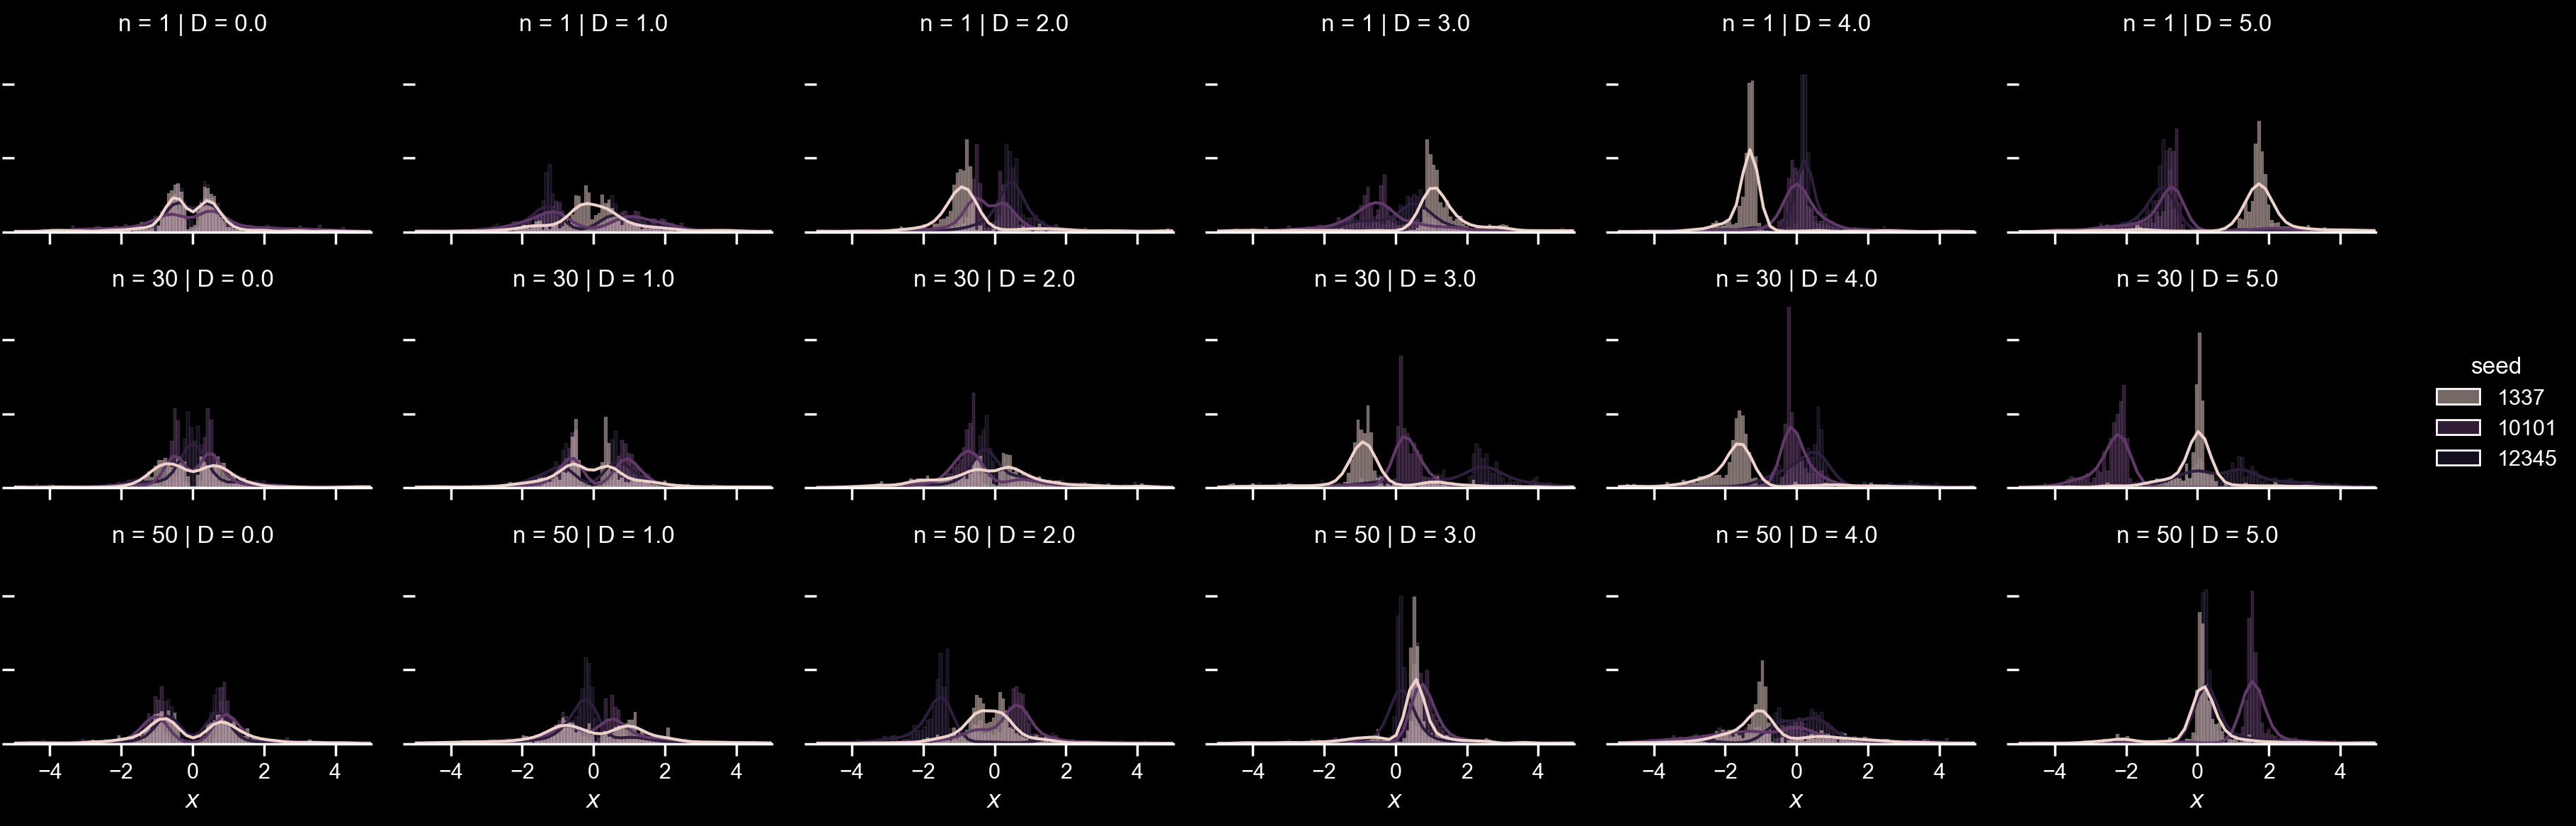

In [7]:
# explore the data

g = sns.displot(
    (
        df_rdn_same
        .to_pandas_df()
        .rename(columns={"sample_size": "n", "opinion": OPINION_SYMBOL})
    ),
    x=OPINION_SYMBOL,
    hue="seed",
    # palette=sns.color_palette("husl", n_colors=3),
    # hue="D",
    col="D",
    # col_wrap=2,
    row="n",
    height=2,
    aspect=1.5,
    kind="hist",
    stat="probability",
    kde=True,
    fill=True,
    kde_kws=dict(
        bw_adjust=0.5,
    ),
)
sns.despine(left=True)
g.set(xlim=(-5, 5), ylabel="", yticklabels=[])


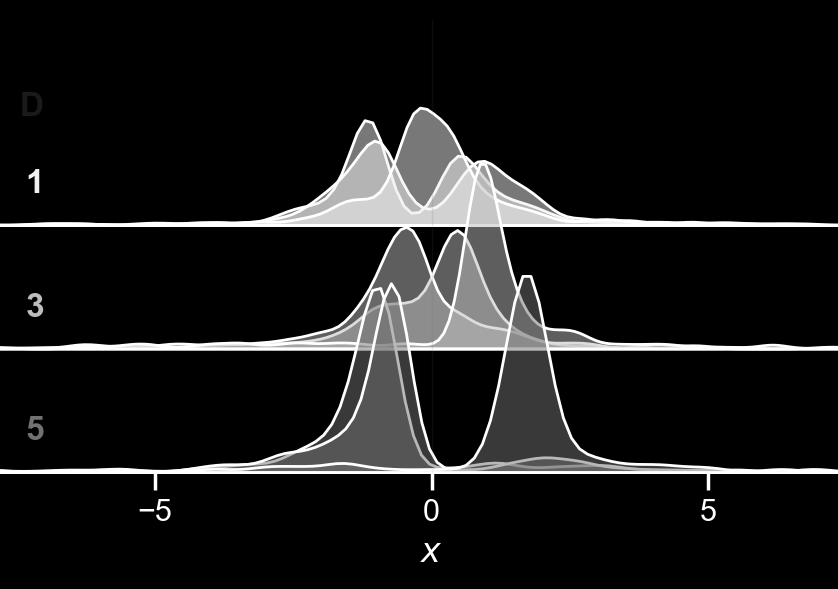

In [8]:
# pretty plot (Figure 2d in the paper)
run_d = sorted(df_rdn_same["D"].unique())
run_d = [1, 3, 5]

seeds = sorted(df_rdn_same["seed"].unique())
fig, axes = plt.subplots(len(run_d), figsize=(5, 3), sharex=False, sharey=True)
bw_adjust = 0.5

pd_df = df_rdn_same.to_pandas_df().rename(
    columns={"sample_size": "n", "opinion": OPINION_SYMBOL}
)
# ensure only unique runs are plotted per trace
pd_df = pd_df[(pd_df["background"] == True)&(pd_df["n"] == 1)]

pal = sns.color_palette("Greys", n_colors=len(run_d) * 2 + 1)

for i, D in enumerate(run_d):
    sns.kdeplot(
        data=pd_df[(pd_df["D"] == D)],
        x=OPINION_SYMBOL,
        hue="seed",
        palette=sns.blend_palette(
            [pal[i * 2], pal[i * 2]], n_colors=len(seeds), input="hex"
        ),
        ax=axes[i],
        # color=pal[i],
        bw_adjust=bw_adjust,
        clip_on=False,
        fill=True,
        alpha=0.5,
        linewidth=1,
        edgecolor="w",
        legend=False,
        zorder=100,
    )
    axes[i].set(ylabel="", yticks=[], yticklabels=[], xlim=(-5, 5))

    axes[i].text(
        0,
        0.2,
        f"{D:.0f}",
        fontweight="bold",
        color=pal[i * 2],
        ha="right",
        va="center",
        transform=axes[i].transAxes,
        zorder=100,
    )
    for x_line in [0]:
        axes[i].axvline(
            x=x_line, color="grey", alpha=0.1, linestyle="-", lw=0.5, zorder=100
        )
    if i < len(run_d) - 1:
        axes[i].set(xticks=[], xlabel="")
    if i == 0:
        axes[i].text(
            0,
            0.5,
            "D",
            fontweight="bold",
            color="k",
            ha="right",
            va="bottom",
            transform=axes[i].transAxes,
            zorder=100,
        )
    axes[i].set(xlim=(-8, 8))

fig.subplots_adjust(hspace=-0.4)
axes[-1].set_xlim(-7, 7)
axes[-1].set_xticks([-5, 0, 5])
# fig.subplots_adjust(hspace=0.01)
sns.despine(left=True, bottom=True)

fig.savefig("output/fig2d.png", transparent=True)

## Run a range of parameters for SampleChamber with **unique** samples per agent

$\mathrm{RDN} = \sqrt {n}\left( {\langle X_{n} \rangle}_i - \langle X \rangle \right)$

In [9]:
parameters = dict(
    N=1000,
    m=10,
    T=5.0,
    epsilon=1e-2,
    gamma=2.1,
    dt=0.01,
    r=0.5,
    update_conn=True,
    cls=SampleChamber,
    method="RK45",
    name="sample chamber",
)

D_range = np.round(np.arange(0.0, 5.0001, 1), 3)

sample_size_range = [1, 10, 30, 50]

range_parameters = {
    "D": {"range": D_range, "title": "D"},
    "sample_size": {"range": sample_size_range, "title": "n"},
    "alpha": {"range": [3], "title": "α"},
    "beta": {"range": [3], "title": "β"},
    "K": {"range": [3], "title": "K"},
    "background": {"range": [True]},
    "sample_method": {
        "range": ["full"],
        "title": "sample method",
    },
    "seed": [1337, 10101, 12345],
}

with LoggingContext(logging.INFO):
    # step 1: run the simulations
    df = Simulation.run_product(
        range_parameters,
        noise_start=0,
        cache=True,
        cache_sim="nudge_range",
        cache_mem=False,
        parallel=10,
        **parameters
    )
    # step 2: load the SampleChamber objects
    print("loading SampleChamber objects")
    nsn_list = Simulation.run_product(
        range_parameters,
        noise_start=0,
        cache=True,
        cache_sim=False,
        cache_mem=True,
        parallel=False,
        **parameters
    )
print(f"{len(nsn_list)} simulations loaded") 
df

INFO:simulation:reading from existing file...
INFO:simulation:running 0 new simulations (out of 72 supplied) in parallel
parallel: 0it [00:00, ?it/s]INFO:simulation:done running
INFO:simulation:changes detected to c:\Users\ccurrin\dev\opinion_dynamics\.cache\nudge_range.h5
INFO:simulation:converting...
parallel: 0it [00:00, ?it/s]
INFO:simulation:saving new version to c:\Users\ccurrin\dev\opinion_dynamics\.cache\nudge_range.hdf5...


export(hdf5) [########################################] 100.00% elapsed time  :     0.29s =  0.0m =  0.0h
 

INFO:simulation:removing conversion directory
INFO:simulation:converted
INFO:simulation:loading full DataFrame from storage
INFO:simulation:


loading SampleChamber objects


D=5.0,sample_size=50,alpha=3,beta=3,K=3,background=True,sample_method=full,seed=12345: 100%|██████████| 72/72 [00:05<00:00, 12.03it/s]
INFO:simulation:done running


72 simulations loaded


#       i    opinion              N     m    T    epsilon    gamma    dt    r    update_conn    name            D    sample_size    alpha    beta    K    background    sample_method    seed    cls    method    activity_distribution
0       0    0.6809600373769773   1000  10   5.0  0.01       2.1      0.01  0.5  True           sample chamber  0.0  1              3        3       3    True          full             1337           RK45
1       1    -0.9285659495949625  1000  10   5.0  0.01       2.1      0.01  0.5  True           sample chamber  0.0  1              3        3       3    True          full             1337           RK45
2       2    0.7438318188932408   1000  10   5.0  0.01       2.1      0.01  0.5  True           sample chamber  0.0  1              3        3       3    True          full             1337           RK45
3       3    1.897225202045162    1000  10   5.0  0.01       2.1      0.01  0.5  True           sample chamber  0.0  1              3        3       3    True          full             1337           RK45
4       4    0.40347111379102263  1000  10   5.0  0.01       2.1      0.01  0.5  True           sample chamber  0.0  1              3        3       3    True          full             1337           RK45
...     ...  ...                  ...   ...  ...  ...        ...      ...   ...  ...            ...             ...  ...            ...      ...     ...  ...           ...              ...     ...    ...       ...
89,995  995  -2.9555587787183133  1000  10   5.0  0.01       2.1      0.01  0.5  True           sample chamber  5.0  10             3        3       3    True          full             12345          RK45
89,996  996  1.202701648469033    1000  10   5.0  0.01       2.1      0.01  0.5  True           sample chamber  5.0  10             3        3       3    True          full             12345          RK45
89,997  997  -1.1987261316542082  1000  10   5.0  0.01       2.1      0.01  0.5  True           sample chamber  5.0  10             3        3       3    True          full             12345          RK45
89,998  998  -1.0698779789981887  1000  10   5.0  0.01       2.1      0.01  0.5  True           sample chamber  5.0  10             3        3       3    True          full             12345          RK45
89,999  999  -1.731438091504514   1000  10   5.0  0.01       2.1      0.01  0.5  True           sample chamber  5.0  10             3        3       3    True          full             12345          RK45

### show neighbours for specific D and sample size (part of Figure 2f)

In [ ]:
for nsn in nsn_list:
    if nsn.D in [1, 2, 3] and nsn.sample_size == 30:
        vsn = VisSocialNetwork(nsn)
        fig, ax_joint, ax_marg_x, ax_marg_y = vsn.show_nearest_neighbour(title=f"{nsn.D} | {nsn.seed}")
        ax_joint.set(xlim=(-5, 5), ylim=(-5,5))

### check effect of sample size  (part of Figure 2f)

masking
plotting
saving


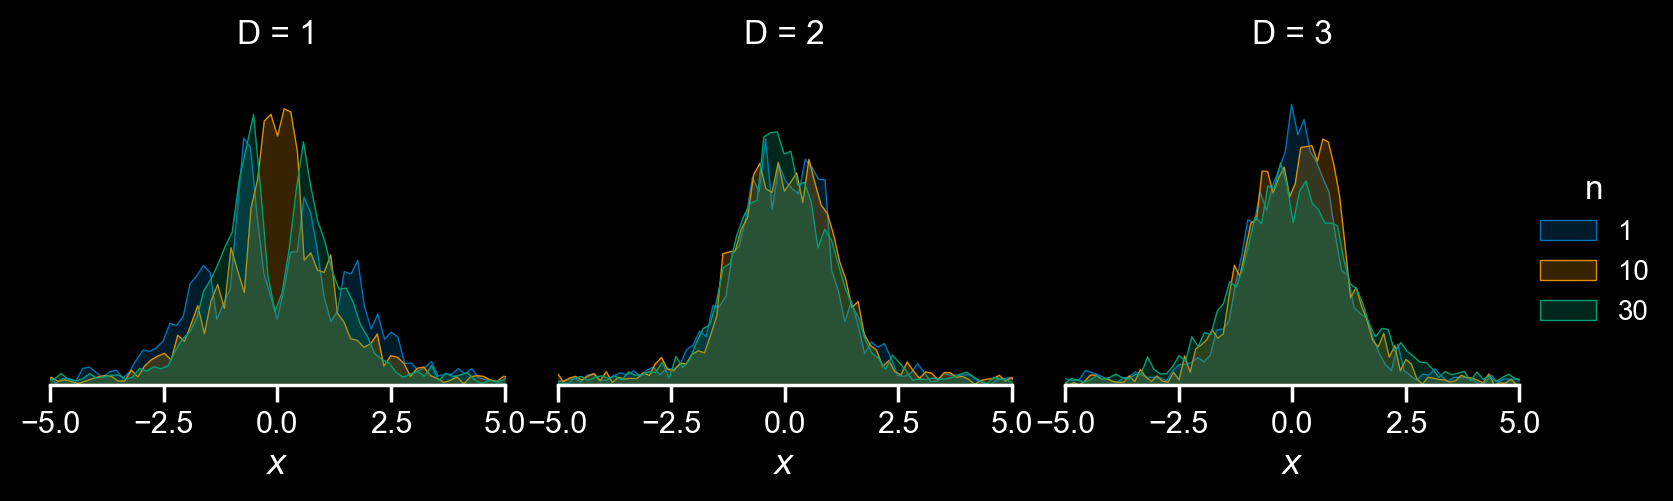

In [11]:

α = range_parameters["alpha"]["range"][0]
β = range_parameters["beta"]["range"][0]
K = range_parameters["K"]["range"][0]

defaults = {
    "alpha": α,
    "K": K,
    "beta": β,
}
sub_D_range = [1.0, 2.0, 3.0]
col_wrap = len(sub_D_range) // 2
sub_sample_range = [1, 10, 30]
print("masking")
sub_df = (
    df_multi_mask(
        df[(df["D"].isin(sub_D_range)) & (df["sample_size"].isin(sub_sample_range))],
        defaults,
    )
    .to_pandas_df()
    .rename({"sample_size": "n", "opinion": OPINION_SYMBOL}, axis=1)
)
print("plotting")

sns.set_palette(sns.color_palette("colorblind", len(sub_sample_range)))
n_cols = len(sub_D_range)
n_rows = 1
width = 8 / n_cols
aspect = 1
height = width / aspect
grid_kwargs = dict(
    sharex=True,
    sharey=True,
    margin_titles=False,
    legend_out=True,
    height=height,
    aspect=aspect,
)
kde_kwargs = dict(lw=0.5, bw_adjust=0.1)
sub_df["D"] = sub_df["D"].astype(int)
g = sns.FacetGrid(sub_df, col="D", hue="n", **grid_kwargs)

kde_kwargs.setdefault("fill", True)
kde_kwargs.setdefault("thresh", 1)
g.map(sns_kdeplot, OPINION_SYMBOL, **kde_kwargs)
g.set(xlim=(-5, 5), ylim=(0, g.axes[0,0].get_ylim()[1] * 1.1))
for ax in g.axes.flatten():
    ax.set_xlabel(f"{OPINION_SYMBOL}")
    ax.set_ylabel(f"")
    sns.despine(ax=ax, left=True)
    ax.set_yticks([])
g.add_legend(fontsize="small")
for line in g._legend.get_lines():
    line.set_linewidth(1.0)
for f, f_ax in enumerate(g.axes.flatten()):
    y_data_max = (
        max(
            [
                max(l.get_paths()[0].vertices[:, 1])
                for l in f_ax.get_children()
                if isinstance(l, PolyCollection)
            ]
        )
        * 0.96
    )
    y_max = f_ax.get_ylim()[1] * 1.05
    color = "grey"
    # f_ax.annotate(
    #     PEAK_DISTANCE,
    #     xy=(0, y_data_max),
    #     xytext=(0, y_max),
    #     arrowprops=dict(
    #         arrowstyle=f"-[,widthB={max(0.35-0.1*f**1.5,0)}",
    #         color="k",
    #         alpha=0.7,
    #         lw=0.5,
    #     ),
    #     alpha=0.8,
    #     fontsize="x-small",
    #     va="center",
    #     ha="center",
    # )
print("saving")
g.savefig("output/fig2f.png", transparent=True)

# Figure 2 (a b c e)

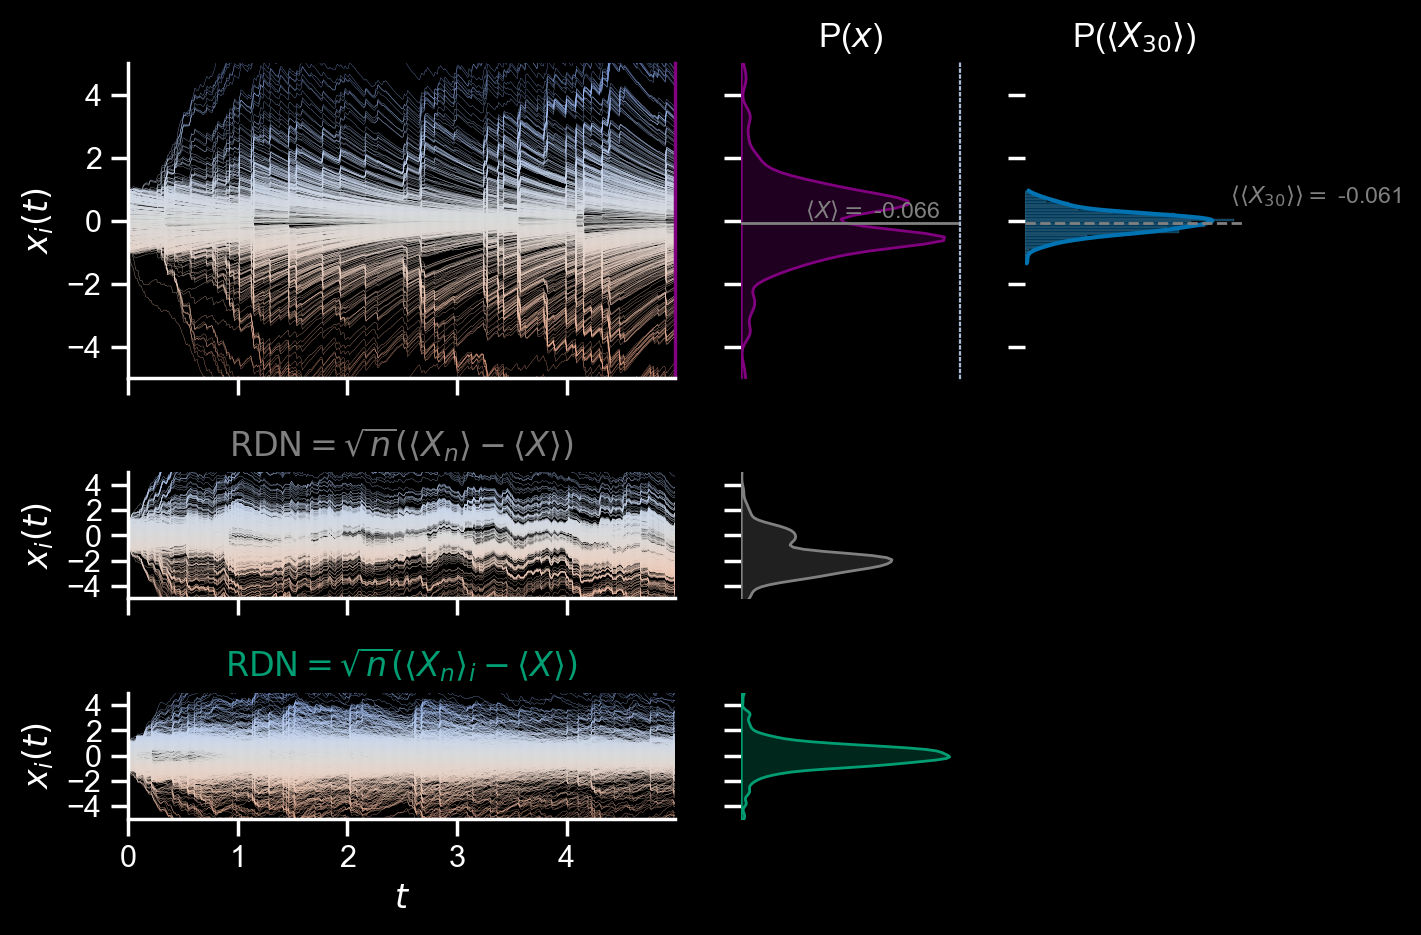

In [12]:
# title Figure 2 (a b c e) { display-mode: "form" }

sample_size = 30
num_samples = 1000

fig, axes = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(7.2, 5),
    gridspec_kw={"width_ratios": [1, 0.4, 0.4], "height_ratios": [1, 0.4, 0.4]},
    sharey=True,
    sharex="col",
)
fig.subplots_adjust(hspace=0.5)
# fig.subplots_adjust(wspace=0.05)
VisSocialNetwork(sn_polar).show_opinions(
    "line", ax=axes[0, 0], title="", rasterized=True
)
sns.kdeplot(
    y=sn_polar.opinions,
    ax=axes[0, 1],
    shade=True,
    bw_adjust=0.5,
    color="Purple",
)
sample_means = sn_polar.get_sample_means(sample_size, num_samples)
mu = np.mean(sample_means)

sns.histplot(y=sample_means, kde=True, ax=axes[0, 2])

ax = axes[0, -1]
ax.annotate(
    f"$ \langle \langle X_{{{sample_size}}} \\rangle \\rangle =$ {mu:.3f}",
    xy=(ax.get_xlim()[1], mu),
    xytext=(-5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize="x-small",
    color="gray",
    # arrowprops=dict(arrowstyle='-|>'),
)
ax.axhline(y=mu, color="gray", linestyle="--", lw=1)

ax = axes[0, -2]
true_mu = np.mean(sn_polar.opinions)
ax.annotate(
    f"$\langle X \\rangle =$ {true_mu:.3f}",
    xy=(ax.get_xlim()[1], true_mu),
    xytext=(-5, 0),
    textcoords="offset points",
    ha="right",
    va="bottom",
    fontsize="x-small",
    # arrowprops=dict(arrowstyle='-|>'),
    zorder=100,
    clip_on=False,
    color="gray",
)
ax.axhline(y=true_mu, color="gray", linestyle="-", lw=1)

axes[0, -2].set_title(f"P({OPINION_SYMBOL})")
axes[0, -1].set_title(f"P($\langle X_{{{sample_size}}} \\rangle$)")
# ax.set_ylabel(f"$P(\overline{{X}}_n)$\n[# samples = {num_samples}]")
# ax.set(yticks=False,)
sns.despine(ax=axes[0, 0], right=False)
axes[0, 0].spines["right"].set_color("Purple")
axes[0, 0].set_xlabel("")

for ax in axes[0, -2:]:
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set(xticks=[], xlabel="")
axes[0, -2].spines["right"].set_visible(True)
axes[0, -2].spines["right"].set_color("#abbdd9")
axes[0, -2].spines["right"].set_linestyle(":")
axes[0, -2].spines["right"].set_linewidth(0.8)

# plot with noise
ax_d_n1 = axes[1, 0]
ax_d_nN = axes[2, 0]
VisSocialNetwork(sn_D_n1).show_opinions(
    "line", ax=ax_d_n1, title="", rasterized=True
)
VisSocialNetwork(sn_D_nN).show_opinions(
    "line", ax=ax_d_nN, title="", rasterized=True
)

d_color = "grey"

dN_colors = sns.color_palette("colorblind", 3)
sns.set_palette(dN_colors)

dN_color = "#57AC8E"
dN_color = dN_colors[-1]
ax_d_n1.set_xlabel("")

sns.kdeplot(
    y=sn_D_n1.opinions, ax=axes[1, 1], shade=True, bw_adjust=0.5, color=d_color
)
sns.kdeplot(
    y=sn_D_nN.opinions, ax=axes[2, 1], shade=True, bw_adjust=0.5, color=dN_color
)
ax_d_n1.spines["top"].set_color(d_color)
ax_d_n1.spines["right"].set_color(d_color)
ax_d_n1.spines["top"].set_linewidth(2)
ax_d_n1.set_title(
    "$\\mathrm{RDN} = \\sqrt {n}\\left( \\langle X_{n} \\rangle - \\langle X \\rangle \\right)$",
    color=d_color,
    # weight="bold"
)
ax_d_nN.spines["top"].set_color(dN_color)
ax_d_nN.spines["right"].set_color(dN_color)
ax_d_nN.spines["top"].set_linewidth(2)
ax_d_nN.set_title(
    "$\\mathrm{RDN} = \\sqrt {n}\\left( {\\langle X_{n} \\rangle}_i - \\langle X \\rangle \\right)$",
    color=dN_color,
    # weight="bold"
)

axes[0, 0].set_ylim(-5, 5)

for ax in axes[1:, 1]:
    sns.despine(ax=ax, left=True, bottom=True)

for ax in axes[1, 2:]:
    ax.remove()

for ax in axes[2, 2:]:
    ax.remove()


fig.savefig("output/fig2abce.png", dpi=400)
